In [1]:
%load_ext autoreload

In [36]:
%autoreload 2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm import tqdm, trange
from timeit import timeit
from IPython.display import display, SVG
import graphviz

from ttn_torch import TIndex, TTNIndex, TTN, TTNModel, check_correct_init
from algebra import contract_up
from utils import *
from torchinfo import summary

FONTSIZE = 14

# Read tensors from TAIS files

In [6]:
numpy_to_torch_dtype_dict = {
        np.uint8      : torch.uint8,
        np.int8       : torch.int8,
        np.int16      : torch.int16,
        np.int32      : torch.int32,
        np.int64      : torch.int64,
        np.float16    : torch.float16,
        np.float32    : torch.float32,
        np.float64    : torch.float64,
        np.complex64  : torch.complex64,
        np.complex128 : torch.complex128
    }

In [7]:
elements_dir = 'trenti_models/metis/'
dtype = np.float64

with open(elements_dir + 'elements.bin') as f:
    n_elements = np.fromfile(f, dtype=np.int32, count=1)[0]
    
elements = np.fromfile(elements_dir + 'elements.bin', dtype=dtype, offset=4) # skip the first 4 bytes (int32 header containing the number of elements)
modes_file = open(elements_dir + 'modes.txt', 'r')

In [8]:
print('elements:', elements.shape, n_elements)

elements: (1792,) 1792


In [9]:
modes_file.seek(13)
line = modes_file.readline()
leg_tags = []
leg_dims = []
tensor_dict = {}
offset = 0
n_tensors = 0
while line:
    if line != '\n':
        splits = line.strip('\n').split(' ')
        leg_tags.append(splits[0])
        leg_dims.append(int(splits[1]))
    else:
        layer, layer_idx = [int(i) for i in leg_tags[-1].split(',')[-1].split('.')]
        tindex = TTNIndex(layer, layer_idx)
        print(f"read tensor {n_tensors}:", tindex, "\twith legs_dim:", leg_dims)
        n_tensors += 1
        n_elements = np.prod(leg_dims)
        tensor = torch.tensor(elements[offset:offset + n_elements], dtype=numpy_to_torch_dtype_dict[dtype]).reshape(list(np.array(leg_dims)[[2, 1, 0]])).permute(2, 1, 0)
        offset += n_elements
        tensor_dict[tindex] = tensor
        leg_tags.clear()
        leg_dims.clear()
    line = modes_file.readline()

layer, layer_idx = 0, 0
tindex = TTNIndex(layer, layer_idx)
print(f"read tensor {n_tensors}:", tindex, "\twith legs_dim:", leg_dims)   
n_elements = np.prod(leg_dims)
tensor = torch.tensor(elements[offset:offset + n_elements], dtype=numpy_to_torch_dtype_dict[dtype]).reshape(list(np.array(leg_dims)[[2, 1, 0]])).permute(2, 1, 0)
offset += n_elements
tensor_dict[tindex] = tensor
leg_tags.clear()
leg_dims.clear()

read tensor 0: 3.0 	with legs_dim: [2, 2, 4]
read tensor 1: 3.1 	with legs_dim: [2, 2, 4]
read tensor 2: 3.2 	with legs_dim: [2, 2, 4]
read tensor 3: 3.3 	with legs_dim: [2, 2, 4]
read tensor 4: 3.4 	with legs_dim: [2, 2, 4]
read tensor 5: 3.5 	with legs_dim: [2, 2, 4]
read tensor 6: 3.6 	with legs_dim: [2, 2, 4]
read tensor 7: 3.7 	with legs_dim: [2, 2, 4]
read tensor 8: 2.0 	with legs_dim: [4, 4, 8]
read tensor 9: 2.1 	with legs_dim: [4, 4, 8]
read tensor 10: 2.2 	with legs_dim: [4, 4, 8]
read tensor 11: 2.3 	with legs_dim: [4, 4, 8]
read tensor 12: 1.0 	with legs_dim: [8, 8, 8]
read tensor 13: 1.1 	with legs_dim: [8, 8, 8]
read tensor 14: 0.0 	with legs_dim: [8, 8, 2]


# construct TTN

In [10]:
sorted_tensors = {k: v for k, v in sorted(tensor_dict.items(), key=lambda item: item[0])}
last_key = list(sorted_tensors.keys())[-1]
first_key = list(sorted_tensors.keys())[0]
n_feat = 2**(last_key.layer+1)
n_phys = sorted_tensors[last_key].shape[0]
n_labels = sorted_tensors[first_key].shape[-1]
bond_dim = sorted_tensors[first_key].shape[1]

In [11]:
ttn = TTNModel(n_features=n_feat, n_phys=n_phys, n_labels=n_labels, bond_dim=bond_dim, dtype=numpy_to_torch_dtype_dict[dtype], device='cuda')
ttn.tensors = list(sorted_tensors.values())
ttn.initialize(False)

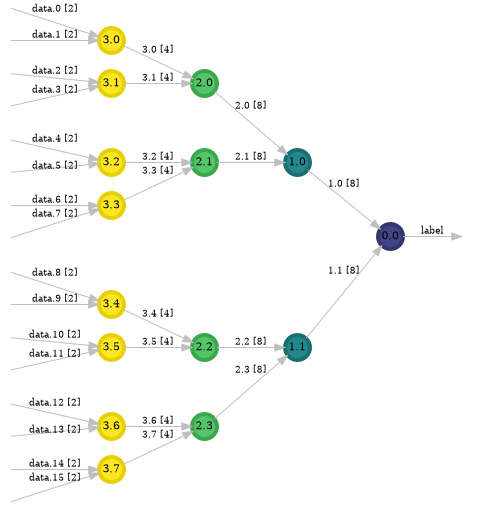

In [12]:
ttn.draw()

In [12]:
summary(ttn, input_size=(10, n_feat, n_phys), device='cuda', dtypes=[numpy_to_torch_dtype_dict[dtype]])

Layer (type:depth-idx)                   Output Shape              Param #
TTNModel                                 [10, 2]                   1,792
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [20]:
np.savez(elements_dir + f'weights.npz', **{key.name : value.cpu().detach() for key, value in ttn._TTN__tensor_map.items()})

# Load data and predict

In [1]:
def spinMap(x: np.ndarray):
    cos = np.cos(x*np.pi/2)
    sin = np.sin(x*np.pi/2)
        
    assert(np.allclose(cos**2 + sin**2, 1.0))
    return np.stack((cos, sin), axis=-1)

def polyMap(x: np.ndarray, dim: int=2):
    p_n = [x**i for i in range(dim)]
    result = np.stack(p_n, axis=-1)
    result /= np.linalg.norm(result, axis=-1, keepdims=True)
    assert(np.allclose(np.sum(result**2, axis=-1), 1.0))
    return result


mappings_dict = { 'spin': spinMap, 'poly': polyMap }

NameError: name 'np' is not defined

In [12]:
imsize = '8x16'
datadir = '../data/stripeimages/'
n_samples = 10000
mapping = 'poly'

x_train = np.load(datadir + imsize + 'train.npy')[:n_samples]
y_train = np.load(datadir + imsize + 'train_labels.npy')[:n_samples]
x_test = np.load(datadir + imsize + 'test.npy')[:n_samples]
y_test = np.load(datadir + imsize + 'test_labels.npy')[:n_samples]

x_train = mappings_dict[mapping](x_train.reshape(x_train.shape[0], -1))
x_test = mappings_dict[mapping](x_test.reshape(x_test.shape[0], -1))

x_train = torch.tensor(x_train, dtype=numpy_to_torch_dtype_dict[dtype], device='cuda')
x_test = torch.tensor(x_test, dtype=numpy_to_torch_dtype_dict[dtype], device='cuda')

true_pred_train = np.loadtxt(elements_dir + '../train1/predictions_train.txt')
true_pred_test = np.loadtxt(elements_dir + '../train1/predictions_test.txt')
gpu_pred_cpp = np.loadtxt(elements_dir + 'gpu_predictions_batch.txt')
print('x_train:', x_train.shape, '\ny_train:', y_train.shape, '\nx_test:', x_test.shape, '\ny_test:', y_test.shape, '\ntrue_pred:', true_pred_train.shape)

x_train: torch.Size([10000, 128, 2]) 
y_train: (10000,) 
x_test: torch.Size([1000, 128, 2]) 
y_test: (1000,) 
true_pred: (10000, 2)


In [13]:
x_test[0,0]

tensor([0.7071, 0.7071], device='cuda:0', dtype=torch.float64)

In [14]:
ttn.eval()
pred_time = timeit(lambda: ttn(x_train), number=100)/100
gpu_pred_train = ttn(x_train).cpu().detach().numpy()
gpu_pred_test = ttn(x_test).cpu().detach().numpy()

In [15]:
pred_time / x_train.shape[0]

1.6944516189978456e-06

In [16]:
np.sum(gpu_pred_cpp, axis=1).mean(), np.sum(gpu_pred_train, axis=1).mean(), np.sum(gpu_pred_test, axis=1).mean()

(0.0293920694230278, 0.029408259626954206, 0.029392068654420782)

In [22]:
np.allclose(gpu_pred_test, gpu_pred_cpp, rtol=1e-6, atol=1e-5)

True

In [32]:
gpu_prob_train = gpu_pred_train**2 + 1e-18
gpu_prob_test = gpu_pred_test**2 + 1e-18

gpu_prob_train = gpu_prob_train / np.sum(gpu_prob_train, axis=1, keepdims=True)
gpu_prob_test = gpu_prob_test / np.sum(gpu_prob_test, axis=1, keepdims=True)
gpu_prob_test

array([[9.99975250e-01, 2.47498627e-05],
       [9.99999837e-01, 1.63425463e-07],
       [9.99996373e-01, 3.62692386e-06],
       ...,
       [9.99999922e-01, 7.82640517e-08],
       [1.94366401e-06, 9.99998056e-01],
       [1.00000000e+00, 4.80882487e-10]])

In [18]:
gpu_prob_train = gpu_pred_train
gpu_prob_test = gpu_pred_test

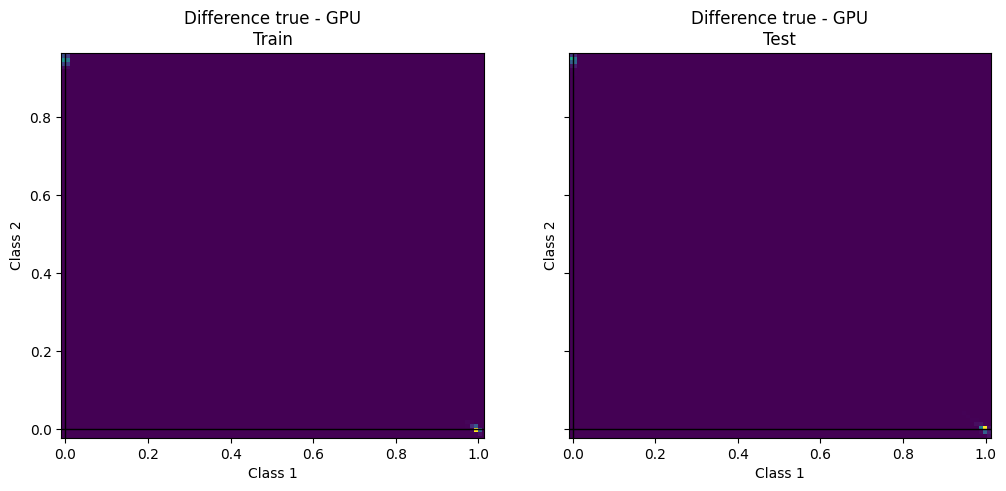

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
axs[0].hist2d(*(true_pred_train-gpu_prob_train).T, bins=100)
axs[0].set_title("Difference true - GPU\nTrain")
axs[0].set_xlabel("Class 1")
axs[0].set_ylabel("Class 2")
#ax.set_xlim(-1, 1)
#ax.set_ylim(-0.5, 1)

axs[0].axhline(0, color='black', lw=1)
axs[0].axvline(0, color='black', lw=1)


axs[1].hist2d(*(true_pred_test-gpu_prob_test).T, bins=100)
axs[1].set_title("Difference true - GPU\nTest")
axs[1].set_xlabel("Class 1")
axs[1].set_ylabel("Class 2")
#ax.set_xlim(-1, 1)
#ax.set_ylim(-0.5, 1)

axs[1].axhline(0, color='black', lw=1)
axs[1].axvline(0, color='black', lw=1)

#fig.savefig(f'difference_f{x_test.shape[1]}_c{8}_id{0}.png', dpi=600)

## BB data

In [31]:
train_dl, test_dl, features = get_bb_data_loaders(1000)

In [39]:
ttn.eval()
ttn.to('cuda')

train_out = get_output(ttn, 'cuda', train_dl)
test_out = get_output(ttn, 'cuda', test_dl)

np.save('trenti_models/bd8/train_out.npy', train_out)
np.save('trenti_models/bd8/test_out.npy', test_out)

train_out.sum(axis=1).mean(), test_out.sum(axis=1).mean()


test:   0%|          | 0/1000 [00:00<?, ?it/s]

test: 100%|██████████| 110/110 [00:00<00:00, 112.93it/s]


(tensor(0.9875, dtype=torch.float64), tensor(0.9871, dtype=torch.float64))

In [40]:
train_data = []
test_data = []

train_labels = []
test_labels = []

for x, y in train_dl:
    train_data.append(x)
    train_labels.append(y)

for x, y in test_dl:
    test_data.append(x)
    test_labels.append(y)

train_data = torch.cat(train_data, dim=0)
test_data = torch.cat(test_data, dim=0)
train_labels = torch.cat(train_labels, dim=0)
test_labels = torch.cat(test_labels, dim=0)

np.save('../data/bbdata/train_data.npy', train_data.cpu().detach().numpy())
np.save('../data/bbdata/test_data.npy', test_data.cpu().detach().numpy())
np.save('../data/bbdata/train_labels.npy', train_labels.cpu().detach().numpy())
np.save('../data/bbdata/test_labels.npy', test_labels.cpu().detach().numpy())
